In [1]:
!pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

  Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)
  Using cached scikit_learn-1.2.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.1
    Uninstalling joblib-1.0.1:
      Successfully uninstalled joblib-1.0.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
pip install pymorphy2


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install nltk


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install plotly


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import os
import re
import json
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
from sklearn.feature_extraction.text import (
    TfidfVectorizer, 
    CountVectorizer
)
from datetime import datetime, timedelta
import pymorphy2 as pm
import nltk
N_CORES = min(
    multiprocessing.cpu_count(), 
    int(float(os.environ['CPU_LIMIT']))
)
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
print('cores:', N_CORES)
pd.set_option('display.max_colwidth', 100)

cores: 3


In [7]:
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score, 
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_curve, 
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay
)

## 1. Data preparation

In [8]:
df = pd.read_csv('posts.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913 entries, 0 to 5912
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          5913 non-null   int64  
 1   col_text_x          4647 non-null   object 
 2   col_from_id         5913 non-null   int64  
 3   col_owner_id        5913 non-null   int64  
 4   col_views_count     2850 non-null   float64
 5   col_reposts_count   5908 non-null   float64
 6   col_likes_count     5913 non-null   int64  
 7   col_comments_count  5913 non-null   int64  
 8   col_date            5913 non-null   object 
 9   group               5913 non-null   object 
 10  col_video_id        5913 non-null   int64  
 11  has_photo           5913 non-null   int64  
 12  col_lang            5913 non-null   object 
 13  col_sent            5913 non-null   object 
 14  sent_prob           5913 non-null   float64
dtypes: float64(3), int64(7), object(5)
memory usage: 693.1+

In [10]:
df.head()

,Unnamed: 0,col_text_x,col_from_id,col_owner_id,col_views_count,col_reposts_count,col_likes_count,col_comments_count,col_date,group,col_video_id,has_photo,col_lang,col_sent,sent_prob
0,0,NaN,-23777199,-23777199,375.0,0.0,13,0,2023-05-19 13:55:23,gsom_abiturient,0,1,th,unknown,0.000000
1,0,"⚡⚡ Будь активным! Это девиз выпускника ВШМ СПбГУ Хантера Кейвуда. Как он работает на практике, Х...",-20449089,-20449089,255.0,1.0,2,0,2023-05-18 16:23:00,gsom_ma,0,0,th,unknown,0.000000
2,0,ВШМ СПбГУ вошла в тройку лидеров среди российских вузов — участников предметных рейтингов Агентс...,-168,-168,425.0,3.0,5,0,2023-05-23 12:46:46,gsom_spbu,0,1,th,unknown,0.000000
3,1,Может ли Minecraft быть полезным для управления проектами? Конечно же да 🙌\n \nСтуденты и выпуск...,-23777199,-23777199,917.0,4.0,4,0,2023-05-15 14:42:00,gsom_abiturient,1,0,ru,neutral,0.996736
4,1,Может ли Minecraft быть полезным для управления проектами? Конечно же да 🙌 \n \nСтуденты и выпус...,-20449089,-20449089,542.0,1.0,3,0,2023-05-15 15:23:00,gsom_ma,0,0,ru,neutral,0.996736


In [11]:
## приводим к московскому времени, добавляем дни недели
df['col_date'] = pd.to_datetime(df.col_date, format='%Y-%m-%d %H:%M:%S')
df['col_date'] = df['col_date'] + timedelta(hours=3)
df['day_of_week'] = df['col_date'].dt.dayofweek

In [12]:
# Set day & nighttime based your specified time frames
df.loc[df.set_index('col_date').index.indexer_between_time('00:00', '5:30'), 'd-n'] = 'night'
df.loc[df.set_index('col_date').index.indexer_between_time('5:30', '11:59'), 'd-n'] = 'morning'
df.loc[df.set_index('col_date').index.indexer_between_time('11:59', '16:00'), 'd-n'] = 'day'
df.loc[df.set_index('col_date').index.indexer_between_time('16:00', '00:00'), 'd-n'] = 'evening'

In [13]:
# Set day & nighttime based your specified time frames
df['month'] = df['col_date'].dt.month
df['year'] = df['col_date'].dt.year

In [14]:
df.col_likes_count.describe()

count    5913.000000
mean        8.343142
std        16.393776
min         0.000000
25%         1.000000
50%         3.000000
75%        10.000000
max       474.000000
Name: col_likes_count, dtype: float64

In [15]:
##переменная лайков: так как квартиль это 3 лайка, то в бинарной переменной 0, когда лайков <3, 1 - когда больше
df.loc[(df["col_likes_count"] >= 3), 'like_presense']='1'
df.loc[(df["col_likes_count"] < 4), 'like_presense']='0'

In [16]:
df['like_presense'] = df['like_presense'].fillna(0)
df['like_presense'] = df['like_presense'].astype(str).astype (int)

In [17]:
## Удаляем репосты
df = df.dropna(subset=['col_text_x'])
df.shape

(4647, 20)

In [18]:
## Посты, совершенные внешними пользователями. Рекламные посты или посты во время, когда кгруппа была неофициальной
df.loc[df['col_from_id'] != df['col_owner_id']]

,Unnamed: 0,col_text_x,col_from_id,col_owner_id,col_views_count,col_reposts_count,col_likes_count,col_comments_count,col_date,group,col_video_id,has_photo,col_lang,col_sent,sent_prob,day_of_week,d-n,month,year,like_presense
1596,532,"Здравствуйте,хочу учится по направлению маркетинг,какие экзамены нужно сдавать для этого?заранее...",277997748,-23777199,NaN,0.0,0,1,2015-03-07 19:30:47,gsom_abiturient,0,1,ru,neutral,0.997724,5,evening,3,2015,0
1599,533,Добрый день! а подскажите пожалуйста за что отчисляют из спбгу вшм (баклавриат) в плане академич...,167248684,-23777199,NaN,1.0,0,1,2013-06-26 21:27:30,gsom_abiturient,0,1,ru,neutral,0.995808,2,evening,6,2013,0
1602,534,А в каком месте строится новый кампус ВШМ?,13448472,-23777199,NaN,0.0,0,3,2013-04-03 12:26:25,gsom_abiturient,0,0,ru,neutral,0.998253,2,day,4,2013,0
1605,535,"Скажите пожалуйста, когда дни открытых дверей будут?",39389159,-23777199,NaN,0.0,0,1,2013-01-28 23:05:25,gsom_abiturient,0,0,ru,neutral,0.997733,0,evening,1,2013,0
1608,536,"ребят, сложно учиться на международного менеджмента?",40187092,-23777199,NaN,0.0,0,1,2012-05-10 14:52:32,gsom_abiturient,0,0,ru,neutral,0.997904,3,day,5,2012,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5908,3972,"Да уже все поняли, нафига дважды писать?:)",584249,-168,NaN,0.0,0,0,2008-08-27 16:02:10,gsom_spbu,0,0,th,unknown,0.000000,2,evening,8,2008,0
5909,3973,уважаемые студенты СПбГУ(кроме первых курсов)!кто хочет принять участие в организации Точки Отсч...,1012889,-168,NaN,0.0,0,0,2008-08-17 15:00:14,gsom_spbu,0,0,th,unknown,0.000000,6,day,8,2008,0
5910,3974,спасибо,375969,-168,NaN,0.0,0,0,2008-08-17 12:11:52,gsom_spbu,1,0,th,unknown,0.000000,6,day,8,2008,0
5911,3975,с 25,421507,-168,NaN,0.0,0,0,2008-08-15 16:47:42,gsom_spbu,1,0,th,unknown,0.000000,4,evening,8,2008,0


In [19]:
df.like_presense.value_counts()

1    2755
0    1892
Name: like_presense, dtype: int64

In [20]:
df = df.loc[df['col_from_id'] == df['col_owner_id']]

In [21]:
## Видим, что есть пропущенные значения в views. В вк просмотры появились только с 2016 года, так что заменим на 0
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3763 entries, 1 to 5677
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Unnamed: 0          3763 non-null   int64         
 1   col_text_x          3763 non-null   object        
 2   col_from_id         3763 non-null   int64         
 3   col_owner_id        3763 non-null   int64         
 4   col_views_count     2806 non-null   float64       
 5   col_reposts_count   3763 non-null   float64       
 6   col_likes_count     3763 non-null   int64         
 7   col_comments_count  3763 non-null   int64         
 8   col_date            3763 non-null   datetime64[ns]
 9   group               3763 non-null   object        
 10  col_video_id        3763 non-null   int64         
 11  has_photo           3763 non-null   int64         
 12  col_lang            3763 non-null   object        
 13  col_sent            3763 non-null   object      

In [22]:
df.rename(columns={"col_video_id": "has_video"}, inplace=True)
df.columns

Index(['Unnamed: 0', 'col_text_x', 'col_from_id', 'col_owner_id',
       'col_views_count', 'col_reposts_count', 'col_likes_count',
       'col_comments_count', 'col_date', 'group', 'has_video', 'has_photo',
       'col_lang', 'col_sent', 'sent_prob', 'day_of_week', 'd-n', 'month',
       'year', 'like_presense'],
      dtype='object')

In [23]:
df['col_views_count'] = df['col_views_count']. fillna (0)

In [24]:
#Выборка несбалансированна
df['like_presense'].value_counts()

1    2755
0    1008
Name: like_presense, dtype: int64

In [25]:
# by likes
df.sort_values(by='col_likes_count', ascending=False).head(2)

,Unnamed: 0,col_text_x,col_from_id,col_owner_id,col_views_count,col_reposts_count,col_likes_count,col_comments_count,col_date,group,has_video,has_photo,col_lang,col_sent,sent_prob,day_of_week,d-n,month,year,like_presense
3339,1403,"#GSOMachievements #GSOMsuccess\n\nПервый день лета, первый день работы Петербургского международ...",-168,-168,49010.0,71.0,474,0,2017-06-01 11:15:24,gsom_spbu,0,0,ru,positive,0.987339,3,morning,6,2017,1
3254,1333,#GSOMachievements\n\n⚡ВШМ СПбГУ в топ-25 лучших программ магистратуры в мире⚡\n\nПрограмма Maste...,-168,-168,31106.0,56.0,374,0,2017-09-11 13:51:38,gsom_spbu,0,0,ru,neutral,0.996655,0,day,9,2017,1


In [26]:
del df[df.columns [0]]

In [27]:
#Оказалось, что есть посты-дубликаты.
duplicateRows = df[df.duplicated (subset= ['col_text_x','col_owner_id','col_views_count', 'col_likes_count', 'col_date'])]
duplicateRows.head(3)

,col_text_x,col_from_id,col_owner_id,col_views_count,col_reposts_count,col_likes_count,col_comments_count,col_date,group,has_video,has_photo,col_lang,col_sent,sent_prob,day_of_week,d-n,month,year,like_presense


In [28]:
df = df.drop_duplicates(subset= ['col_text_x','col_owner_id','col_views_count', 'col_likes_count', 'col_date'])
df.shape

(3763, 19)

In [29]:
pattern = '🔔 Регистрация на «Олимпиаду для первых» продлена! \n\nМы получили много обращений с просьбой'
df.loc[(df['col_text_x'].str.contains(pattern, case=False, na=False))]

,col_text_x,col_from_id,col_owner_id,col_views_count,col_reposts_count,col_likes_count,col_comments_count,col_date,group,has_video,has_photo,col_lang,col_sent,sent_prob,day_of_week,d-n,month,year,like_presense
96,🔔 Регистрация на «Олимпиаду для первых» продлена! \n\nМы получили много обращений с просьбой про...,-23777199,-23777199,801.0,1.0,3,0,2023-02-27 16:30:00,gsom_abiturient,0,0,ru,neutral,0.997669,0,evening,2,2023,0
103,🔔 Регистрация на «Олимпиаду для первых» продлена! \n\nМы получили много обращений с просьбой про...,-20449089,-20449089,470.0,2.0,2,0,2023-02-27 16:30:00,gsom_ma,0,0,ru,neutral,0.998429,0,evening,2,2023,0
278,🔔 Регистрация на «Олимпиаду для первых» продлена! \n\nМы получили много обращений с просьбой про...,-168,-168,1498.0,5.0,5,0,2023-02-27 16:30:00,gsom_spbu,0,1,ru,neutral,0.993785,0,evening,2,2023,1


In [30]:
#Оказалось, что есть посты-дубликаты по тексту в разных группах.
#duplicateRows = df[df.duplicated (subset= ['col_text_x'])]
#duplicateRows

In [31]:
#df = df.drop_duplicates(subset= ['col_text_x'])

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3763 entries, 1 to 5677
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   col_text_x          3763 non-null   object        
 1   col_from_id         3763 non-null   int64         
 2   col_owner_id        3763 non-null   int64         
 3   col_views_count     3763 non-null   float64       
 4   col_reposts_count   3763 non-null   float64       
 5   col_likes_count     3763 non-null   int64         
 6   col_comments_count  3763 non-null   int64         
 7   col_date            3763 non-null   datetime64[ns]
 8   group               3763 non-null   object        
 9   has_video           3763 non-null   int64         
 10  has_photo           3763 non-null   int64         
 11  col_lang            3763 non-null   object        
 12  col_sent            3763 non-null   object        
 13  sent_prob           3763 non-null   float64     

In [33]:
df['group'].value_counts()

gsom_spbu          1997
gsom_ma            1250
gsom_abiturient     516
Name: group, dtype: int64

In [34]:
print(df.loc[df['group'] == 'gsom_spbu']['col_comments_count'].sum())
print(df.loc[df['group'] == 'gsom_ma']['col_comments_count'].sum())
print(df.loc[df['group'] == 'gsom_abiturient']['col_comments_count'].sum())

612
513
185


In [35]:
df.loc[df['group'] == 'gsom_spbu'].describe()

,col_from_id,col_owner_id,col_views_count,col_reposts_count,col_likes_count,col_comments_count,has_video,has_photo,sent_prob,day_of_week,month,year,like_presense
count,1997.0,1997.0,1997.000000,1997.000000,1997.000000,1997.000000,1997.000000,1997.000000,1997.000000,1997.000000,1997.000000,1997.000000,1997.000000
mean,-168.0,-168.0,1449.036054,2.555333,16.636455,0.306460,0.047571,0.299449,0.934412,2.245869,6.578368,2018.336505,0.788182
std,0.0,0.0,1846.351721,6.576250,24.416867,1.312123,0.212911,0.458131,0.237879,1.661825,3.502861,2.878281,0.408699
min,-168.0,-168.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,0.000000
25%,-168.0,-168.0,761.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.997188,1.000000,3.000000,2017.000000,1.000000
50%,-168.0,-168.0,1273.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.998026,2.000000,6.000000,2018.000000,1.000000
75%,-168.0,-168.0,1879.000000,2.000000,20.000000,0.000000,0.000000,1.000000,0.998273,4.000000,10.000000,2021.000000,1.000000
max,-168.0,-168.0,49010.000000,104.000000,474.000000,32.000000,1.000000,1.000000,0.998651,6.000000,12.000000,2023.000000,1.000000


In [36]:
df.loc[df['group'] == 'gsom_ma'].describe()

,col_from_id,col_owner_id,col_views_count,col_reposts_count,col_likes_count,col_comments_count,has_video,has_photo,sent_prob,day_of_week,month,year,like_presense
count,1250.0,1250.0,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000
mean,-20449089.0,-20449089.0,576.212000,1.468000,6.300800,0.410400,0.098400,0.230400,0.973629,2.478400,6.362400,2017.693600,0.56240
std,0.0,0.0,1406.912738,2.981289,8.540719,1.952696,0.297974,0.421257,0.145644,1.772017,3.544618,3.536796,0.49629
min,-20449089.0,-20449089.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,0.00000
25%,-20449089.0,-20449089.0,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.997578,1.000000,3.000000,2015.000000,0.00000
50%,-20449089.0,-20449089.0,454.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.998104,2.000000,6.000000,2018.000000,1.00000
75%,-20449089.0,-20449089.0,794.000000,2.000000,7.000000,0.000000,0.000000,0.000000,0.998306,4.000000,10.000000,2021.000000,1.00000
max,-20449089.0,-20449089.0,43826.000000,34.000000,108.000000,35.000000,1.000000,1.000000,0.998651,6.000000,12.000000,2023.000000,1.00000


In [37]:
df.loc[df['group'] == 'gsom_abiturient'].describe()

,col_from_id,col_owner_id,col_views_count,col_reposts_count,col_likes_count,col_comments_count,has_video,has_photo,sent_prob,day_of_week,month,year,like_presense
count,516.0,516.0,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000
mean,-23777199.0,-23777199.0,1198.746124,3.751938,11.091085,0.358527,0.120155,0.228682,0.992552,2.542636,6.339147,2020.715116,0.926357
std,0.0,0.0,813.240360,6.490359,8.611656,1.253091,0.325458,0.420392,0.047519,1.725909,3.449398,1.233136,0.261443
min,-23777199.0,-23777199.0,266.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2018.000000,0.000000
25%,-23777199.0,-23777199.0,743.750000,0.000000,6.000000,0.000000,0.000000,0.000000,0.997572,1.000000,3.000000,2020.000000,1.000000
50%,-23777199.0,-23777199.0,960.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.998120,3.000000,6.000000,2021.000000,1.000000
75%,-23777199.0,-23777199.0,1343.250000,5.000000,14.000000,0.000000,0.000000,0.000000,0.998318,4.000000,10.000000,2022.000000,1.000000
max,-23777199.0,-23777199.0,7701.000000,69.000000,60.000000,10.000000,1.000000,1.000000,0.998651,6.000000,12.000000,2023.000000,1.000000


In [38]:
# by likes
df.sort_values(by='col_likes_count', ascending=False).head(2)

,col_text_x,col_from_id,col_owner_id,col_views_count,col_reposts_count,col_likes_count,col_comments_count,col_date,group,has_video,has_photo,col_lang,col_sent,sent_prob,day_of_week,d-n,month,year,like_presense
3339,"#GSOMachievements #GSOMsuccess\n\nПервый день лета, первый день работы Петербургского международ...",-168,-168,49010.0,71.0,474,0,2017-06-01 11:15:24,gsom_spbu,0,0,ru,positive,0.987339,3,morning,6,2017,1
3254,#GSOMachievements\n\n⚡ВШМ СПбГУ в топ-25 лучших программ магистратуры в мире⚡\n\nПрограмма Maste...,-168,-168,31106.0,56.0,374,0,2017-09-11 13:51:38,gsom_spbu,0,0,ru,neutral,0.996655,0,day,9,2017,1


In [39]:
# likes by days
#time_axis = df.sort_values('col_date')
#likes_count = df.sort_values('col_date')['col_likes_count'].collect()

In [40]:
#plt.figure(figsize=(16, 6))
#plt.plot(df['col_date'], df['col_likes_count'])
#plt.ylabel('likes')
#plt.xlabel('timestamp')
#plt.title('Likes over the time')
#plt.legend(['likes'], loc='upper left')
#plt.show()

<AxesSubplot:title={'center':'Comments by day of week'}, xlabel='Day of week', ylabel='Number of comments'>

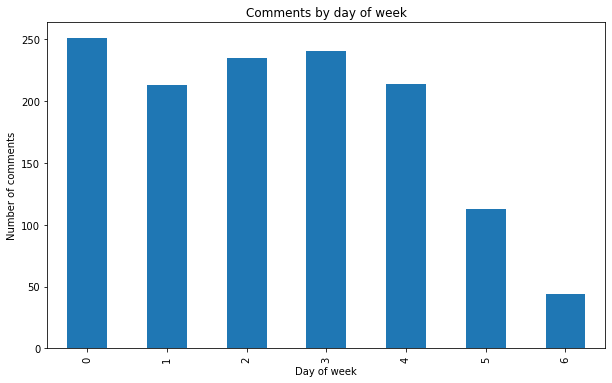

In [41]:
comments_dow = df.groupby('day_of_week')['col_comments_count'].sum()
comments_dow.plot(kind='bar', title='Comments by day of week',
               ylabel='Number of comments', xlabel='Day of week', figsize=(10, 6))

<AxesSubplot:title={'center':'Likes by day of week'}, xlabel='Day of week', ylabel='Number of likes'>

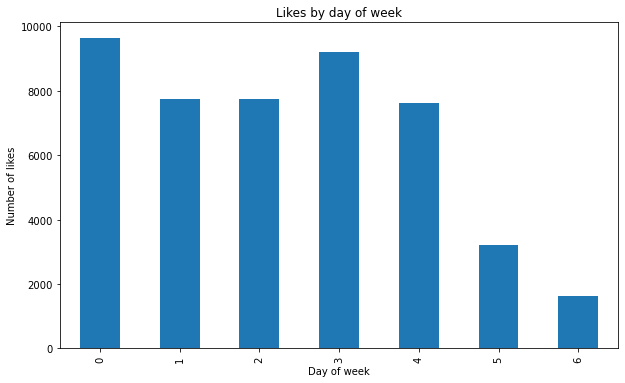

In [42]:
likes_dow = df.groupby('day_of_week')['col_likes_count'].sum()
likes_dow.plot(kind='bar', title='Likes by day of week',
               ylabel='Number of likes', xlabel='Day of week', figsize=(10, 6))

<AxesSubplot:title={'center':'Likes by time of the day'}, xlabel='Time of the day', ylabel='Number of likes'>

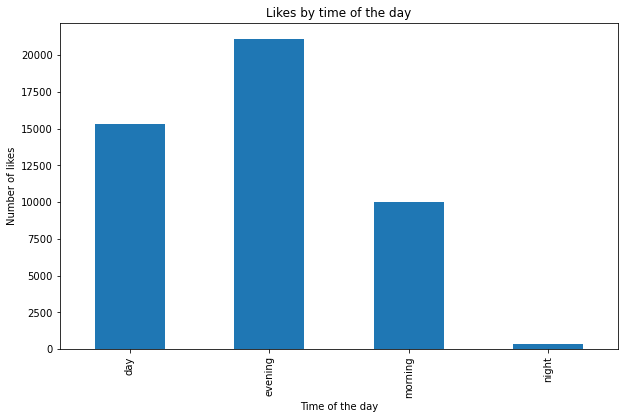

In [43]:
likes_dn = df.groupby('d-n')['col_likes_count'].sum()
likes_dn.plot(kind='bar', title='Likes by time of the day',
               ylabel='Number of likes', xlabel='Time of the day', figsize=(10, 6))

<AxesSubplot:title={'center':'Comments by time of the day'}, xlabel='Time of the day', ylabel='Number of comments'>

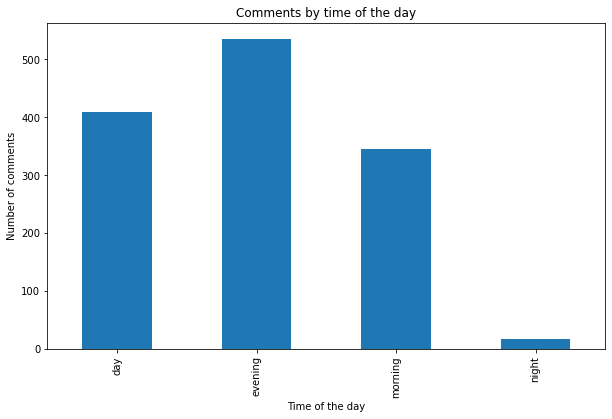

In [44]:
comments_dn = df.groupby('d-n')['col_comments_count'].sum()
comments_dn.plot(kind='bar', title='Comments by time of the day',
               ylabel='Number of comments', xlabel='Time of the day', figsize=(10, 6))

<AxesSubplot:>

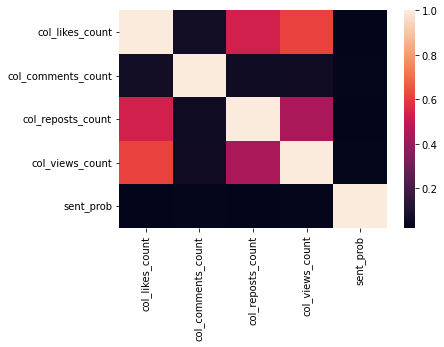

In [45]:
sns.heatmap(df[['col_likes_count','col_comments_count','col_reposts_count','col_views_count','sent_prob']].corr())

In [46]:
corr = df[['col_likes_count','col_comments_count','col_reposts_count','col_views_count','sent_prob']].corr()
corr.style.background_gradient(cmap='RdYlGn')

,col_likes_count,col_comments_count,col_reposts_count,col_views_count,sent_prob
col_likes_count,1.000000,0.069098,0.533399,0.615483,0.021669
col_comments_count,0.069098,1.000000,0.059106,0.061493,0.030395
col_reposts_count,0.533399,0.059106,1.000000,0.433052,0.023876
col_views_count,0.615483,0.061493,0.433052,1.000000,0.032941
sent_prob,0.021669,0.030395,0.023876,0.032941,1.000000


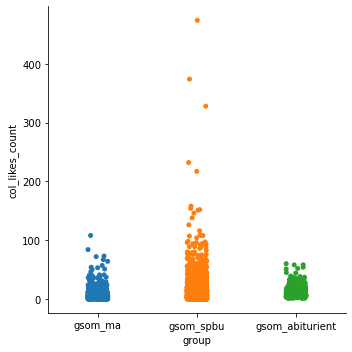

In [47]:
sns.catplot(data=df, x="group", y="col_likes_count")

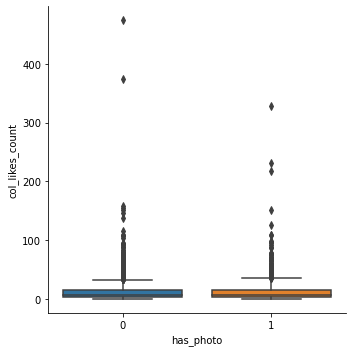

In [48]:
sns.catplot(data=df, x="has_photo", y="col_likes_count", kind="box")

In [49]:
df.col_likes_count.describe()

count    3763.000000
mean       12.442732
std        19.308214
min         0.000000
25%         3.000000
50%         7.000000
75%        15.000000
max       474.000000
Name: col_likes_count, dtype: float64

In [50]:
#sns.catplot(data=df, x="group", y="col_likes_count", hue="has_photo", kind="swarm")

## OneHotEncoder

In [51]:
nominal_features = ['group', 'has_photo', 'day_of_week', 'd-n', 'month']
df[nominal_features].tail(3)

,group,has_photo,day_of_week,d-n,month
5656,gsom_spbu,0,3,evening,5
5664,gsom_spbu,0,1,day,4
5677,gsom_spbu,0,0,evening,3


In [52]:
df = pd.get_dummies(data=df, columns=['group', 'day_of_week', 'd-n', 'month'])

In [53]:
df.head(2)

,col_text_x,col_from_id,col_owner_id,col_views_count,col_reposts_count,col_likes_count,col_comments_count,col_date,has_video,has_photo,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
1,"⚡⚡ Будь активным! Это девиз выпускника ВШМ СПбГУ Хантера Кейвуда. Как он работает на практике, Х...",-20449089,-20449089,255.0,1.0,2,0,2023-05-18 19:23:00,0,0,...,0,0,1,0,0,0,0,0,0,0
2,ВШМ СПбГУ вошла в тройку лидеров среди российских вузов — участников предметных рейтингов Агентс...,-168,-168,425.0,3.0,5,0,2023-05-23 15:46:46,0,1,...,0,0,1,0,0,0,0,0,0,0


## 2. Text processing

In [54]:
LANG = 'russian'

In [55]:
MORPH = pm.MorphAnalyzer()
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words(LANG)
STOPWORDS = STOPWORDS + ['https', 'http', 'vk', 'cc', 'clck', 'ru', 'www', 'com', 'id', 'in','это','it','to','up','of','all', 'день',
                        'and','the','наш','ваш','почему','очень','многое','ещё','весь', 'весь', 'свой', 'который', 'с', 'спбгу',
                        'spbu', 'вшм', 'студент', 'gsom', 'ma', 'мочь', 'группа', 'год']


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
def preprocessing(sentence, as_list=False):
    s = re.sub('[^а-яА-Яa-zA-Z]+', ' ', sentence).strip().lower()
    s = re.sub('ё', 'е', s)
    funсtion_words = {'INTJ', 'PRCL', 'CONJ', 'PREP'}
    lemmatized_words = list(map(lambda word: MORPH.parse(word)[0], s.split()))
    result = []
    for word in lemmatized_words:
        if word.tag.POS not in funсtion_words:
            result.append(word.normal_form)
    result = [w for w in result if w not in STOPWORDS]
    if as_list:
        return result
    else:
        return ' '.join(result)
    
def apply_parallel(texts, func, n_cores=2):
    pool = Pool(n_cores)
    split = np.array_split(texts, n_cores)
    res = [item for sub in pool.map(func, split) for item in sub]
    pool.close()
    pool.join()
    return res

def preprocessing_list(sentences):
    return [preprocessing(s) for s in sentences]

In [57]:
%%time
proc = apply_parallel(df.col_text_x, preprocessing_list, n_cores=N_CORES)

CPU times: user 23.1 ms, sys: 35.4 ms, total: 58.5 ms
Wall time: 18.2 s


In [58]:
df.loc[:, 'proc'] = proc
print(df.shape)
df.head(1)

(3763, 42)


,col_text_x,col_from_id,col_owner_id,col_views_count,col_reposts_count,col_likes_count,col_comments_count,col_date,has_video,has_photo,...,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,proc
1,"⚡⚡ Будь активным! Это девиз выпускника ВШМ СПбГУ Хантера Кейвуда. Как он работает на практике, Х...",-20449089,-20449089,255.0,1.0,2,0,2023-05-18 19:23:00,0,0,...,0,1,0,0,0,0,0,0,0,активный девиз выпускник хантер кейвуд работать практика хантереть рассказывать новый выпуск под...


In [59]:
#df['proc'].loc[0]

In [60]:
from collections import Counter
Counter(" ".join(df["proc"]).split()).most_common(100)

[('программа', 2113),
 ('бизнес', 1562),
 ('школа', 1389),
 ('менеджмент', 1207),
 ('компания', 920),
 ('магистратура', 869),
 ('club', 858),
 ('проект', 782),
 ('вопрос', 747),
 ('новый', 726),
 ('выпускник', 719),
 ('пройти', 665),
 ('работа', 660),
 ('курс', 610),
 ('ссылка', 589),
 ('получить', 587),
 ('рассказать', 585),
 ('первый', 575),
 ('команда', 574),
 ('обучение', 572),
 ('участие', 570),
 ('мероприятие', 555),
 ('узнать', 551),
 ('регистрация', 548),
 ('высокий', 524),
 ('хороший', 519),
 ('развитие', 506),
 ('сайт', 500),
 ('возможность', 499),
 ('международный', 481),
 ('директор', 476),
 ('время', 475),
 ('онлайн', 471),
 ('россия', 461),
 ('поступление', 451),
 ('стать', 444),
 ('сегодня', 414),
 ('состояться', 406),
 ('управление', 403),
 ('преподаватель', 400),
 ('подробный', 381),
 ('кампус', 374),
 ('лекция', 373),
 ('университет', 370),
 ('участник', 369),
 ('бакалавриат', 366),
 ('презентация', 365),
 ('самый', 363),
 ('абитуриент', 363),
 ('открытый', 362),
 ('в

## 3. Modelling

In [61]:
MAX_DF = .5
MIN_DF = 20

In [62]:
def text_features(data, vectorizer):
    print('total texts:', len(data))
    features = vectorizer.fit_transform(data)
    print(
        'features shape:', features.shape, 
        'max:', np.max(features), 
        'min:', np.min(features)
    )
    return features, vectorizer

In [63]:
%%time
vectorizer=TfidfVectorizer(
    ngram_range=(1, 2), 
    max_df=MAX_DF, 
    min_df=MIN_DF,
    max_features = 300
)
features, vectorizer = text_features(
    df['proc'], 
    vectorizer=vectorizer
)

total texts: 3763
features shape: (3763, 300) max: 1.0 min: 0.0
CPU times: user 472 ms, sys: 33.9 ms, total: 506 ms
Wall time: 505 ms


In [64]:
print(features.todense())

[[0.         0.         0.         ... 0.         0.23823092 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [65]:
train_df = df[df.col_date <= '2021-04-01']
train_df.shape

(2744, 42)

In [66]:
valid_df = df[(df.col_date < '2022-04-01')&(df.col_date > '2021-04-01')]
valid_df.shape

(401, 42)

In [67]:
test_df =  df[df.col_date >= '2022-04-01']
test_df.col_date.sort_values(ascending=True)

502    2022-04-01 15:20:28
1004   2022-04-01 16:28:49
408    2022-04-01 17:35:00
499    2022-04-04 15:22:00
405    2022-04-05 08:41:00
               ...        
11     2023-05-18 13:45:10
1      2023-05-18 19:23:00
8      2023-05-19 14:40:37
5      2023-05-22 20:36:49
2      2023-05-23 15:46:46
Name: col_date, Length: 618, dtype: datetime64[ns]

In [68]:
test_df.shape

(618, 42)

In [69]:
X_train = train_df['proc']
X_valid = valid_df['proc']
X_test = test_df['proc']

### Implementing Imbalanced-Learn

In [70]:
#train_df.columns

In [71]:
X_train, vectorizer = text_features(
    X_train, 
    vectorizer=vectorizer
)
X_test = vectorizer.transform(X_test)
X_valid = vectorizer.transform(X_valid)

total texts: 2744
features shape: (2744, 300) max: 1.0 min: 0.0


In [72]:
y_train = train_df['like_presense']
y_valid = valid_df['like_presense']
y_test = test_df['like_presense']

In [73]:
y_valid.value_counts()

1    317
0     84
Name: like_presense, dtype: int64

In [74]:
y_test.value_counts()

1    538
0     80
Name: like_presense, dtype: int64

In [75]:
np.isnan(X_train.data).any()

False

In [76]:
np.isnan(X_test.data).any()

False

In [77]:
np.isnan(y_train).any()

False

In [78]:
np.isnan(y_test).any()

False

In [79]:
y_train.value_counts()

1    1900
0     844
Name: like_presense, dtype: int64

In [80]:
ROS = RandomOverSampler(random_state=42,sampling_strategy=.5)

In [81]:
#X_train_ros, y_train_ros = ROS.fit_resample(X_train, y_train)
#y_train_ros.value_counts()

In [82]:
X_train_ros = X_train
y_train_ros = y_train

In [83]:
reg = LogisticRegression(penalty='l2', max_iter=100, random_state=42, n_jobs=-1)
reg.fit(X_train_ros, y_train_ros)

LogisticRegression(n_jobs=-1, random_state=42)

In [84]:
reg.score(X_train_ros, y_train_ros)

0.7882653061224489

In [85]:
y_pred_train = reg.predict(X_train_ros)
y_pred = reg.predict(X_test)

In [86]:
y_pred_valid = reg.predict(X_valid)

In [87]:
# Predict probabilities on test set
p_test = reg.predict_proba(X_test) 

# Look at the first 5 probabilities
print(p_test[:5, 1])

[0.94127905 0.80132039 0.87644802 0.87644802 0.97633355]


In [88]:
print("MAE:", round(mean_absolute_error(y_test, y_pred), 4))

MAE: 0.1537


In [89]:
print("ROC AUC:", round(roc_auc_score(y_test, p_test[:, 1]), 4))

ROC AUC: 0.5507


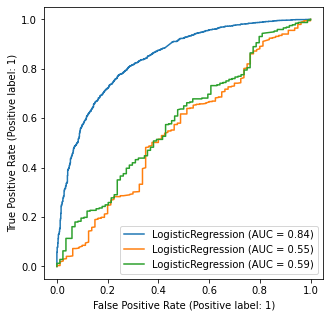

In [90]:
fig, ax = plt.subplots(figsize=(5, 5))

RocCurveDisplay.from_estimator(reg, X_train_ros, y_train_ros, ax=ax)
RocCurveDisplay.from_estimator(reg, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(reg, X_valid, y_valid, ax=ax)

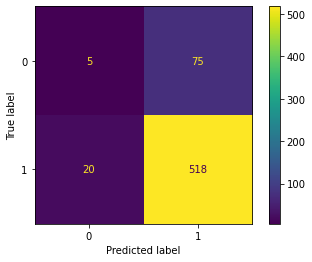

In [91]:
cm = confusion_matrix(y_true=y_test, y_pred=p_test[:, 1]> 0.5) 
cm_display = ConfusionMatrixDisplay(cm).plot()

In [92]:
# Calculating the metrics
def calculating_the_metrics(y, y_p):
    accuracy = accuracy_score(y_true=y, y_pred=y_p)
    precision = precision_score(y_true=y, y_pred=y_p)
    recall = recall_score(y_true=y, y_pred=y_p)
    f1 = f1_score(y_true=y, y_pred=y_p)
    return (accuracy, precision, recall, f1)

In [93]:
def print_the_metrics(df_type, accuracy, precision, recall, f1):
        print(str(df_type) + ' accuracy score: %.2f' % accuracy)
        print(str(df_type) + ' precision score: %.2f' % precision)
        print(str(df_type) + ' recall score: %.2f' % recall)
        print(str(df_type) + ' f1 score: %.2f' % f1)

In [94]:
len(y_pred_train)

2744

In [95]:
accuracy, precision, recall, f1 = calculating_the_metrics(y_train_ros, y_pred_train)
print_the_metrics('Train', accuracy, precision, recall, f1)

Train accuracy score: 0.79
Train precision score: 0.79
Train recall score: 0.95
Train f1 score: 0.86


In [96]:
accuracy, precision, recall, f1 = calculating_the_metrics(y_valid, y_pred_valid)
print_the_metrics('Valid', accuracy, precision, recall, f1)

Valid accuracy score: 0.79
Valid precision score: 0.80
Valid recall score: 0.97
Valid f1 score: 0.88


In [97]:
accuracy, precision, recall, f1 = calculating_the_metrics(y_test, y_pred)
print_the_metrics('Test ', accuracy, precision, recall, f1)

Test  accuracy score: 0.85
Test  precision score: 0.87
Test  recall score: 0.96
Test  f1 score: 0.92


In [98]:
#plt.figure(figsize=(10, 10))
#plt.scatter(y_test, y_pred)
#plt.show()

## RandomForest with Grid Search

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [100]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [101]:
forest_classif = RandomForestClassifier(random_state=42)

In [102]:
param_grid_forest = dict(
    n_estimators=[50, 100, 200],
    max_depth=[3, 5, 7,10]
    )

grid_search_forest = GridSearchCV(estimator=forest_classif, param_grid=param_grid_forest, 
                                  cv=tscv, n_jobs = -1).fit(X_train_ros, y_train_ros)

print("The best hyperparameters are ",grid_search_forest.best_params_)

The best hyperparameters are  {'max_depth': 10, 'n_estimators': 50}


In [103]:
forest_classif = RandomForestClassifier(n_estimators  = grid_search_forest.best_params_["n_estimators"],
                               max_depth = grid_search_forest.best_params_["max_depth"],
                              random_state=42)
forest_classif.fit(X_train_ros, y_train_ros)

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)

In [104]:
y_pred_rf_train = forest_classif.predict(X_train_ros)
y_pred_rf_valid = forest_classif.predict(X_valid)
y_pred_rf_test = forest_classif.predict(X_test)

In [105]:
# Predict probabilities on test set
p_test = forest_classif.predict_proba(X_test) 

# Look at the first 5 probabilities
print(p_test[:5, 1])

[0.80995285 0.70472556 0.73203542 0.73203542 0.84198036]


In [106]:
print("ROC AUC:", round(roc_auc_score(y_test, p_test[:, 1]), 4))

ROC AUC: 0.5827


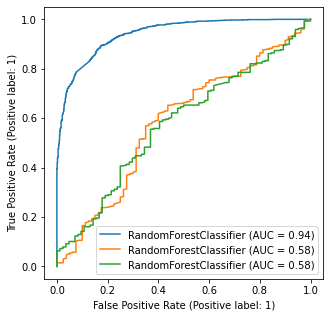

In [107]:
fig, ax = plt.subplots(figsize=(5, 5))

RocCurveDisplay.from_estimator(forest_classif, X_train_ros, y_train_ros, ax=ax)
RocCurveDisplay.from_estimator(forest_classif, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(forest_classif, X_valid, y_valid, ax=ax)

In [108]:
accuracy, precision, recall, f1 = calculating_the_metrics(y_train_ros, y_pred_rf_train)
print_the_metrics('Train ', accuracy, precision, recall, f1)

Train  accuracy score: 0.76
Train  precision score: 0.74
Train  recall score: 1.00
Train  f1 score: 0.85


In [109]:
accuracy, precision, recall, f1 = calculating_the_metrics(y_valid, y_pred_rf_valid)
print_the_metrics('Valid', accuracy, precision, recall, f1)

Valid accuracy score: 0.79
Valid precision score: 0.79
Valid recall score: 0.99
Valid f1 score: 0.88


In [110]:
accuracy, precision, recall, f1 = calculating_the_metrics(y_test, y_pred_rf_test)
print_the_metrics('Test ', accuracy, precision, recall, f1)

Test  accuracy score: 0.87
Test  precision score: 0.87
Test  recall score: 0.99
Test  f1 score: 0.93


# LGBM

In [111]:
pip install lightgbm


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [112]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [113]:
lg = LGBMClassifier(objective='binary', random_state = 42)
lg.fit(X_train_ros, y_train_ros)

LGBMClassifier(objective='binary', random_state=42)

In [114]:
param_grid_lg = dict(
    n_estimators=[50, 100, 200],
    max_depth=[3, 5, 7,10]
    )

grid_search_lg = GridSearchCV(estimator=lg, param_grid=param_grid_lg, 
                                  cv=tscv, n_jobs = -1).fit(X_train_ros, y_train_ros)

print("The best hyperparameters are ",grid_search_lg.best_params_)

The best hyperparameters are  {'max_depth': 10, 'n_estimators': 100}


In [115]:
lg = LGBMClassifier(objective='binary', n_estimators  = grid_search_lg.best_params_["n_estimators"],
                               max_depth = grid_search_lg.best_params_["max_depth"],
                              random_state=42)
lg.fit(X_train_ros, y_train_ros)

LGBMClassifier(max_depth=10, objective='binary', random_state=42)

In [116]:
y_pred_lg_train = lg.predict(X_train_ros)
y_pred_lg_valid = lg.predict(X_valid)
y_pred_lg_test = lg.predict(X_test)

In [117]:
lg.score(X_train_ros, y_train_ros)

0.9048833819241983

In [118]:
# Predict probabilities on test set
p_test = lg.predict_proba(X_test) 

# Look at the first 5 probabilities
print(p_test[:5, 1])

[0.92883414 0.73672295 0.7691997  0.7691997  0.98415914]


In [119]:
print("ROC AUC:", round(roc_auc_score(y_test, p_test[:, 1]), 4))

ROC AUC: 0.5612


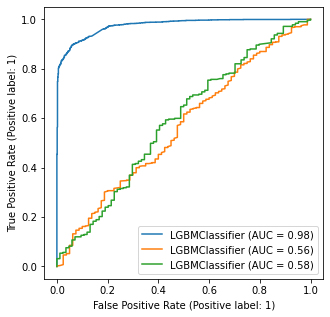

In [120]:
fig, ax = plt.subplots(figsize=(5, 5))

RocCurveDisplay.from_estimator(lg, X_train_ros, y_train_ros, ax=ax)
RocCurveDisplay.from_estimator(lg, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(lg, X_valid, y_valid, ax=ax)

In [121]:
accuracy, precision, recall, f1 = calculating_the_metrics(y_train_ros, y_pred_lg_train)
print_the_metrics('Train ', accuracy, precision, recall, f1)

Train  accuracy score: 0.90
Train  precision score: 0.89
Train  recall score: 0.98
Train  f1 score: 0.93


In [122]:
accuracy, precision, recall, f1 = calculating_the_metrics(y_valid, y_pred_lg_valid)
print_the_metrics('Valid', accuracy, precision, recall, f1)

Valid accuracy score: 0.77
Valid precision score: 0.80
Valid recall score: 0.94
Valid f1 score: 0.87


In [123]:
accuracy, precision, recall, f1 = calculating_the_metrics(y_test, y_pred_lg_test)
print_the_metrics('Test ', accuracy, precision, recall, f1)

Test  accuracy score: 0.83
Test  precision score: 0.87
Test  recall score: 0.95
Test  f1 score: 0.91


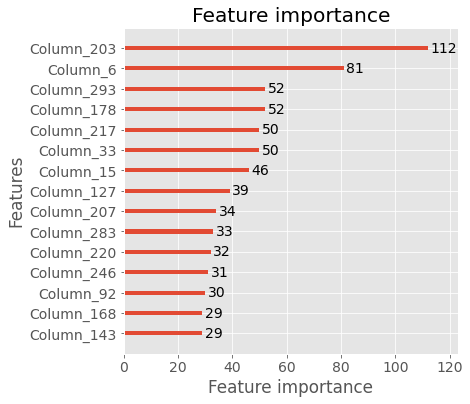

In [124]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14, 'text.color' : "black"})

fig, ax = plt.subplots(figsize=(6, 6))
plot_importance(lg, max_num_features=15, ax=ax)
plt.show();

## Feature importance

In [125]:
feature_importances = pd.DataFrame(forest_classif.feature_importances_)

In [126]:
feature_names = pd.DataFrame(vectorizer.get_feature_names_out())

In [127]:
importances = pd.merge(feature_names, feature_importances, how='inner', left_index = True,  right_index = True)
importances.sort_values(by = ['0_y'], ascending=False).head(20)

,0_x,0_y
19,news,0.053545
190,презентация,0.032150
42,внимание,0.025782
205,программа магистратура,0.025400
164,открыть,0.024639
220,регистрация,0.021569
194,приглашать,0.017905
15,gsomnews,0.017678
217,рассказать,0.016903
191,презентация программа,0.015009


## Trying control variables

In [128]:
train_df.columns

Index(['col_text_x', 'col_from_id', 'col_owner_id', 'col_views_count',
       'col_reposts_count', 'col_likes_count', 'col_comments_count',
       'col_date', 'has_video', 'has_photo', 'col_lang', 'col_sent',
       'sent_prob', 'year', 'like_presense', 'group_gsom_abiturient',
       'group_gsom_ma', 'group_gsom_spbu', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'd-n_day', 'd-n_evening', 'd-n_morning', 'd-n_night',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'proc'],
      dtype='object')

In [129]:
features = ['group_gsom_abiturient', 'group_gsom_ma',
       'group_gsom_spbu', 'd-n_day', 'd-n_evening', 'd-n_morning', 'd-n_night', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'has_video', 'proc']

In [130]:
X_train_new = train_df[features]
X_valid_new = valid_df[features]
X_test_new = test_df[features]

In [131]:
X_train_new.head(1)

,group_gsom_abiturient,group_gsom_ma,group_gsom_spbu,d-n_day,d-n_evening,d-n_morning,d-n_night,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,has_video,proc
684,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,перспектива выпускник гму совмещать работа стартап программа государственный муниципальный управ...


In [132]:
 X_train_text, vectorizer = text_features(
    X_train_new['proc'], 
    vectorizer=vectorizer)

X_test_text = vectorizer.transform(X_test_new['proc'])
X_valid_text = vectorizer.transform(X_valid_new['proc'])

total texts: 2744
features shape: (2744, 300) max: 1.0 min: 0.0


In [133]:
X_train_text = pd.DataFrame.sparse.from_spmatrix(X_train_text)
X_train_text.columns = vectorizer.get_feature_names_out()
X_train_text.head(1)

,abiturient,about,bcg,business,career,cems,club,day,event,events,...,чемпионат,читать,шанс,школа,школа менеджмент,экзамен,эксперт,этап,являться,язык
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.193626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
X_test_text = pd.DataFrame.sparse.from_spmatrix(X_test_text)
X_test_text.columns = vectorizer.get_feature_names_out()
X_test_text.head(1)

,abiturient,about,bcg,business,career,cems,club,day,event,events,...,чемпионат,читать,шанс,школа,школа менеджмент,экзамен,эксперт,этап,являться,язык
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.232998,0.0


In [135]:
X_valid_text = pd.DataFrame.sparse.from_spmatrix(X_valid_text)
X_valid_text.columns = vectorizer.get_feature_names_out()
X_valid_text.head(1)

,abiturient,about,bcg,business,career,cems,club,day,event,events,...,чемпионат,читать,шанс,школа,школа менеджмент,экзамен,эксперт,этап,являться,язык
0,0.312878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
X_train_new.reset_index(drop=True, inplace=True)
X_train_new = pd.concat([X_train_new, X_train_text], axis=1)
X_train_new.head(1)

,group_gsom_abiturient,group_gsom_ma,group_gsom_spbu,d-n_day,d-n_evening,d-n_morning,d-n_night,day_of_week_0,day_of_week_1,day_of_week_2,...,чемпионат,читать,шанс,школа,школа менеджмент,экзамен,эксперт,этап,являться,язык
0,1,0,0,0,0,1,0,1,0,0,...,0.0,0.193626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
X_test_new.reset_index(drop=True, inplace=True)
X_test_new = pd.concat([X_test_new, X_test_text], axis=1)
X_test_new.head(1)

,group_gsom_abiturient,group_gsom_ma,group_gsom_spbu,d-n_day,d-n_evening,d-n_morning,d-n_night,day_of_week_0,day_of_week_1,day_of_week_2,...,чемпионат,читать,шанс,школа,школа менеджмент,экзамен,эксперт,этап,являться,язык
0,0,1,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.232998,0.0


In [138]:
X_valid_new.reset_index(drop=True, inplace=True)
X_valid = pd.concat([X_valid_new, X_valid_text], axis=1)
X_valid.head(1)

,group_gsom_abiturient,group_gsom_ma,group_gsom_spbu,d-n_day,d-n_evening,d-n_morning,d-n_night,day_of_week_0,day_of_week_1,day_of_week_2,...,чемпионат,читать,шанс,школа,школа менеджмент,экзамен,эксперт,этап,являться,язык
0,1,0,0,0,1,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
vectorizer.get_feature_names_out().shape

(300,)

In [140]:
vectorizer.get_feature_names_out()[:3]

array(['abiturient', 'about', 'bcg'], dtype=object)

In [141]:
y_train = train_df['like_presense']
y_valid = valid_df['like_presense']
y_test = test_df['like_presense']

In [142]:
X_train_new = X_train_new.drop(columns=['proc'])
X_valid= X_valid.drop(columns=['proc'])
X_test_new = X_test_new.drop(columns=['proc'])

In [143]:
X_train_new.columns

Index(['group_gsom_abiturient', 'group_gsom_ma', 'group_gsom_spbu', 'd-n_day',
       'd-n_evening', 'd-n_morning', 'd-n_night', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2',
       ...
       'чемпионат', 'читать', 'шанс', 'школа', 'школа менеджмент', 'экзамен',
       'эксперт', 'этап', 'являться', 'язык'],
      dtype='object', length=315)

In [144]:
features = [x for x in X_train_new.columns if x not in ['proc']]

In [145]:
#ROS = RandomOverSampler(random_state=42,sampling_strategy=.45)

In [146]:
#X_train_ros, y_train_ros = ROS.fit_resample(X_train_new, y_train)
#y_train_ros.value_counts()

In [147]:
X_train_ros = X_train_new
y_train_ros = y_train

## Logistic regression with additional features

In [148]:
reg = LogisticRegression(penalty='l2', max_iter=100, random_state=42, n_jobs=-1)
reg.fit(X_train_ros, y_train_ros)

LogisticRegression(n_jobs=-1, random_state=42)

In [149]:
y_pred_tr = reg.predict(X_train_ros)
y_pred_valid = reg.predict(X_valid)
y_pred = reg.predict(X_test_new)

In [150]:
# Predict probabilities on test set
p_test = reg.predict_proba(X_test_new) 

# Look at the first 5 probabilities
print(p_test[:5, 1])

[0.90409272 0.78467221 0.97419129 0.81948925 0.97100256]


In [151]:
from sklearn.metrics import roc_auc_score
print("ROC AUC:", round(roc_auc_score(y_test, p_test[:, 1]), 4))

ROC AUC: 0.6894


In [152]:
reg.score(X_train_ros, y_train_ros)

0.7970116618075802

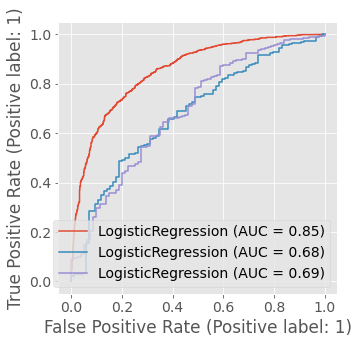

In [153]:
fig, ax = plt.subplots(figsize=(5, 5))

RocCurveDisplay.from_estimator(reg, X_train_ros, y_train_ros, ax=ax)
RocCurveDisplay.from_estimator(reg, X_valid, y_valid, ax=ax)
RocCurveDisplay.from_estimator(reg, X_test_new, y_test, ax=ax)

In [154]:
accuracy, precision, recall, f1 = calculating_the_metrics(y_train_ros, y_pred_tr)
print_the_metrics('Train ', accuracy, precision, recall, f1)

Train  accuracy score: 0.80
Train  precision score: 0.80
Train  recall score: 0.94
Train  f1 score: 0.86


In [155]:
accuracy, precision, recall, f1 = calculating_the_metrics(y_valid, y_pred_valid)
print_the_metrics('Valid', accuracy, precision, recall, f1)

Valid accuracy score: 0.79
Valid precision score: 0.81
Valid recall score: 0.95
Valid f1 score: 0.88


In [156]:
accuracy, precision, recall, f1 = calculating_the_metrics(y_test, y_pred)
print_the_metrics('Test ', accuracy, precision, recall, f1)

Test  accuracy score: 0.87
Test  precision score: 0.89
Test  recall score: 0.97
Test  f1 score: 0.93


## RandomForest with Grid Search

In [157]:
from sklearn.model_selection import GridSearchCV

In [158]:
forest = RandomForestClassifier(random_state=42)

In [159]:
param_grid_forest = dict(
    n_estimators=[50, 100, 200],
    max_depth=[3, 5, 7,10]
    )

grid_search_forest = GridSearchCV(estimator=forest, param_grid=param_grid_forest, 
                                  cv=tscv, n_jobs = -1).fit( X_train_ros, y_train_ros)

print("The best hyperparameters are ",grid_search_forest.best_params_)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/uti

The best hyperparameters are  {'max_depth': 10, 'n_estimators': 200}


In [160]:
forest = RandomForestClassifier(n_estimators  = grid_search_forest.best_params_["n_estimators"],
                               max_depth = grid_search_forest.best_params_["max_depth"],
                              random_state=42)
forest.fit(X_train_ros, y_train_ros)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

In [161]:
y_pred_rf_train = forest.predict(X_train_ros)
y_pred_rf_valid = forest.predict(X_valid)
y_pred_rf = forest.predict(X_test_new)

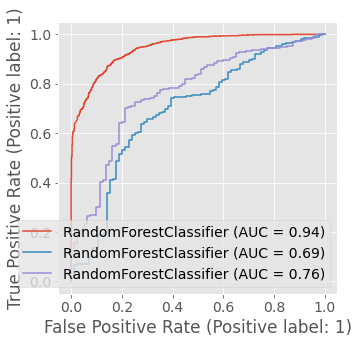

In [162]:
fig, ax = plt.subplots(figsize=(5, 5))

RocCurveDisplay.from_estimator(forest, X_train_ros, y_train_ros, ax=ax)
RocCurveDisplay.from_estimator(forest, X_valid, y_valid, ax=ax)
RocCurveDisplay.from_estimator(forest, X_test_new, y_test, ax=ax)

In [163]:
accuracy, precision, recall, f1 = calculating_the_metrics(y_train_ros, y_pred_rf_train)
print_the_metrics('Train ', accuracy, precision, recall, f1)

Train  accuracy score: 0.77
Train  precision score: 0.75
Train  recall score: 1.00
Train  f1 score: 0.86


In [164]:
accuracy, precision, recall, f1 = calculating_the_metrics(y_valid, y_pred_rf_valid)
print_the_metrics('Valid ', accuracy, precision, recall, f1)

Valid  accuracy score: 0.79
Valid  precision score: 0.79
Valid  recall score: 1.00
Valid  f1 score: 0.88


In [165]:
accuracy, precision, recall, f1 = calculating_the_metrics(y_test, y_pred_rf)
print_the_metrics('Test ', accuracy, precision, recall, f1)

Test  accuracy score: 0.87
Test  precision score: 0.87
Test  recall score: 1.00
Test  f1 score: 0.93


### Light Gradient Boosting Machine

In [166]:
lgbm = LGBMClassifier(objective='binary', random_state = 42)
lgbm.fit(X_train_ros, y_train_ros)

LGBMClassifier(objective='binary', random_state=42)

In [167]:
param_grid_lgbm = dict(
    n_estimators=[50, 100, 200],
    max_depth=[3, 5, 7,10]
    )

grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgbm, 
                                  cv=tscv, n_jobs = -1).fit(X_train_ros, y_train_ros)

print("The best hyperparameters are ",grid_search_lgbm.best_params_)

The best hyperparameters are  {'max_depth': 10, 'n_estimators': 200}


In [168]:
lgbm = LGBMClassifier(objective='binary', n_estimators  = grid_search_lgbm.best_params_["n_estimators"],
                               max_depth = grid_search_lgbm.best_params_["max_depth"],
                              random_state=42)
lgbm.fit(X_train_ros, y_train_ros)

LGBMClassifier(max_depth=10, n_estimators=200, objective='binary',
               random_state=42)

In [169]:
y_pred_lgbm_train = lgbm.predict(X_train_ros)
y_pred_lgbm_valid = lgbm.predict(X_valid)
y_pred_lgbm = lgbm.predict(X_test_new)

In [170]:
lgbm.score(X_train_ros, y_train_ros)

0.9606413994169096

In [171]:
# Predict probabilities on test set
p_test = lgbm.predict_proba(X_test_new) 

# Look at the first 5 probabilities
print(p_test[:5, 1])

[0.95020094 0.70322089 0.97748891 0.83066779 0.99765204]


In [172]:
from sklearn.metrics import roc_auc_score
print("ROC AUC:", round(roc_auc_score(y_test, p_test[:, 1]), 4))

ROC AUC: 0.6372


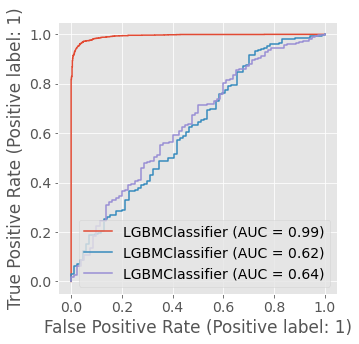

In [173]:
fig, ax = plt.subplots(figsize=(5, 5))

RocCurveDisplay.from_estimator(lgbm, X_train_ros, y_train_ros, ax=ax)
RocCurveDisplay.from_estimator(lgbm, X_valid, y_valid, ax=ax)
RocCurveDisplay.from_estimator(lgbm, X_test_new, y_test, ax=ax)

In [174]:
accuracy, precision, recall, f1 = calculating_the_metrics(y_train_ros, y_pred_lgbm_train)
print_the_metrics('Train ', accuracy, precision, recall, f1)

Train  accuracy score: 0.96
Train  precision score: 0.97
Train  recall score: 0.98
Train  f1 score: 0.97


In [175]:
accuracy, precision, recall, f1 = calculating_the_metrics(y_valid, y_pred_lgbm_valid)
print_the_metrics('Valid ', accuracy, precision, recall, f1)

Valid  accuracy score: 0.80
Valid  precision score: 0.83
Valid  recall score: 0.94
Valid  f1 score: 0.88


In [176]:
accuracy, precision, recall, f1 = calculating_the_metrics(y_test, y_pred_lgbm)
print_the_metrics('Test ', accuracy, precision, recall, f1)

Test  accuracy score: 0.85
Test  precision score: 0.89
Test  recall score: 0.95
Test  f1 score: 0.92


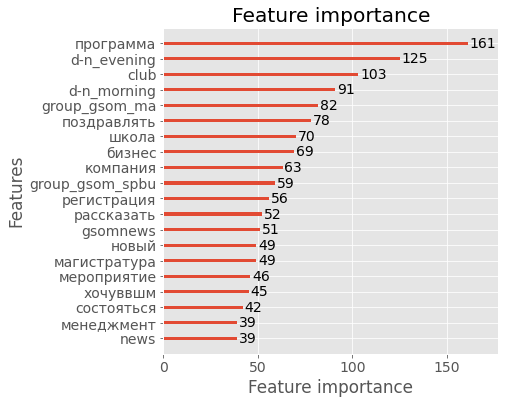

In [177]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14, 'text.color' : "black"})

fig, ax = plt.subplots(figsize=(6, 6))
plot_importance(lgbm, max_num_features=20, ax=ax)
plt.show();

In [184]:
# Extract array of tupels containing word and its weight.

word_coefs = [(f, reg.coef_[0][i]) for f, i in vectorizer.vocabulary_.items()]
word_coefs.sort(key=lambda x: x[1])
word_coefs[:5]

[('выпускница', -1.9926215432180343),
 ('бизнес школа', -1.8277232673736263),
 ('проходить', -1.5962773321068064),
 ('октябрь', -1.5558931056868206),
 ('технология', -1.2513007636955642)]

In [185]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

In [186]:
def draw_word_cloud(word_coefs):
    x, y = np.ogrid[:500, :500]
    mask = (x - 250) ** 2 + (y - 250) ** 2 > 230 ** 2
    mask = 255 * mask.astype(int)
    
    word_cloud = WordCloud(background_color="black", mask=mask)
    word_cloud.generate_from_frequencies(word_coefs)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()